# I'm looking back at the base models

because I'm curious about the role that is played by CLS token in producing the outputs and learning dynamics.
In particular, I intrigued by the idea of sampling over CLS tokens when learning the classifier.

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import seaborn as sns

import numpy as np
import pandas as pd

from tqdm import tqdm

import sys
sys.path.append('../src')
import torch

from pathlib import Path

In [7]:
from models.TTA_model import ClassifierWithTTA

## Question 1: How much does learning the CLS token help?

These training hyper-parameters still need optimization: we see characteristic 'stepping' patterns between epochs. The train loss gets very low.

__Ans:__ it produces a consistent small improvement.

 - These experiments used 2-layer transformer probes. It might be worth trying something similar with linear probe models.


In [37]:
long_probe = pd.read_csv('../experiments_base/accuracy_data/class_token.csv')
long_probe

,train.probe.freeze_cls_token,accuracy
0,True,0.6955
1,False,0.7204


There appears to be a small effect of learning the cls token. The probe accuracies are already pretty good.

I'm a bit surprised to see the high accuracy and the stepping in the probe models
#### Are the weights actually frozen?

Ans: yes.

In [13]:
from models.TTA_model import ClassifierWithTTA

In [14]:
trained_model = ClassifierWithTTA.from_pretrained('../experiments_base/sweeps/2025-11-06(18:02:24)-class_token/0/checkpoints/probe/best')

config.json not found in /Users/luke/Documents/activeProjects/TTA_working/experiments_base/sweeps/2025-11-06(18:02:24)-class_token/0/checkpoints/probe/best


Loading weights from local directory


In [15]:
untrained_model = ClassifierWithTTA()

In [23]:
untrained_p = list(untrained_model.parameters())
trained_p = list(trained_model.parameters())

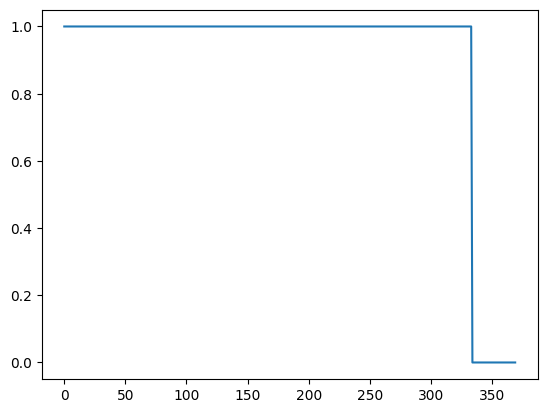

In [25]:
same_weights =[]
for i in range(len(untrained_p)):
    all_close = torch.isclose(untrained_p[i], trained_p[i]).all()
    same_weights.append(int(all_close))

plt.plot(same_weights)

This looks about as expected: recall that we trained a _transformer_ probe, so there is a good amount that can be learned by the transformer alone.

#### Looking back at previous work, this is consistent

We saw little improvement in the classification performance from finetuning the whole model.

Interestingly, finetuning the embedding _did_ produce improvements in the _robustness_ of the model to noise.

### Replicate from previous, shorter (3 epochs vs 10) probe training:

In [44]:
pd.read_csv('../experiments_base/accuracy_data/sweep_probe.csv')

,train.probe.freeze_cls_token,train.full.disable,accuracy
0,True,True,0.7067
1,False,True,0.7200
2,False,False,0.7200
3,True,False,0.7054


Similar effect size and similar accuracy in these earlier runs. Broadly consistent.

In [42]:
pd.read_csv('../experiments_base/accuracy_data/sweep_full.csv')

,train.probe.freeze_cls_token,train.full.disable,accuracy
0,True,True,NaN
1,False,True,NaN
2,False,False,0.7897
3,True,False,0.7911


In this case, the full training actually did result significantly superior performance ~+10%. The difference between probe pretraining with and without frozen cls token is reversed by significantly smaller. I wouldn't bet on it reproducing.

### Debug: sync models produce low accuracies

Are they actually saving the correct models?

In [41]:
pd.read_csv('../experiments_base/accuracy_data/sweep_sync.csv')

,train.probe.freeze_cls_token,train.full.disable,accuracy
0,True,True,0.0041
1,False,True,0.0048
2,False,False,0.0053
3,True,False,0.0061


Given that no encoding parameters should have been trained, this is odd.

Problem solved: need to make sure to merge the trained back into the base model and save that, so that all the weights are saves.

## Random class tokens:

In [45]:
pd.read_csv('../experiments_base/accuracy_data/randomized_probe.csv')

,model.randomized_CLS,accuracy
0,True,0.2417
1,debug,0.7081


Ok. This is about the result that I was expecting. Accuracy suffers seriously when we randomize tokens in the probe only model.

Note that the 'debug' model is essentially the full finetuning model, except that the CLS token is never learned.

In [47]:
pd.read_csv('../experiments_base/accuracy_data/randomized_full.csv')

,model.randomized_CLS,accuracy
0,True,0.7703
1,debug,0.7757


Recovers after finetuning the whole model. This is quite interesting and promising: randomized cls tokens don't impact performance, but offer a way to compare input-output distributions for models that are (or are not) specialized for classification.

Pretty much the ideal setup for applying my thesis work.

The obvious question here is how this impacts on generalization performance and TTA performance.

In [116]:
generalization = pd.read_csv('../experiments_base/accuracy_data/randomized_robustness.csv')

(0.0, 0.75)

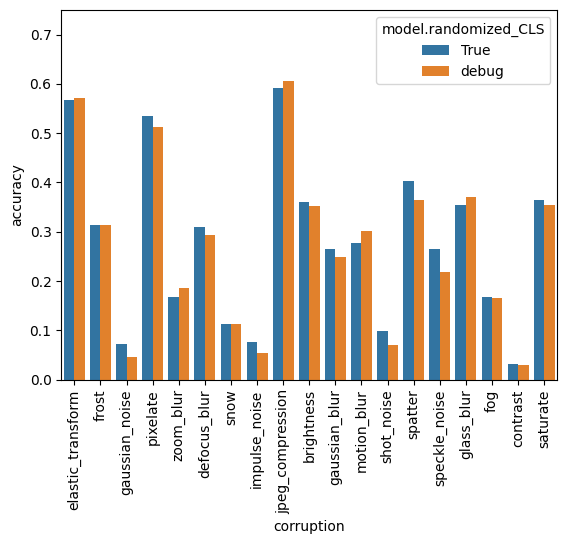

In [127]:
sns.barplot(generalization, x='corruption', y='accuracy', hue='model.randomized_CLS')
_=plt.xticks(rotation=90)
plt.ylim([0, 0.75])

Overall, the generalization is substantially similar between the two, and substantially similar to the previous results. Randomization seems very slightly better in more cases, but certainly not in all cases.

Comparing to the previous (notebook 0.2), these models are generally worse performing by a small amount. ~-5%

- randomized tokens alone _do not_ improve generalization.
- randomized tokens have about the same impact as using a single (not learned) cls token.